In [1]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
from transformers import AutoTokenizer
from torch.utils.data import DataLoader, WeightedRandomSampler
import pprint as pp
from utils.param_objects import EmpatheticDialogueParams, MELDParams
from models.emotimebert import EmotionalTimeBert, DatasetMode
from sklearn.metrics import f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt
from data_handling.datasets.empathetic_dialogues import EmpatheticDialoguesDataset
from data_handling.datasets.meld import MELDDataset
from data_handling.data_cleaning.empathetic_dialogues import load_empath_conversations, load_empath_test_conversations
from data_handling.data_cleaning.meld import load_meld_dfs, load_meld_split, load_meld_conversations, load_meld_test_conversations, emotion_id_to_label, label_to_emotion_id
from utils.utils import train_model, validate_model, test_model, collate_conversations, create_new_run_dir, save_table_as_csv, compute_class_weights, FocalLoss

from pathlib import Path
import re
os.environ["TOKENIZERS_PARALLELISM"] = "false"
TRAINING = True


/home/cayden/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
base_save_location = create_new_run_dir(new_dir=TRAINING)

In [3]:
conversations, val_conversations, emotion_labels, emotion_to_id = load_empath_conversations()
meld_data, val_data = load_meld_dfs()
meld_conversations, val_meld_conversations, meld_emotions, meld_labels = load_meld_conversations()

In [4]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
dataset = MELDDataset(meld_conversations, tokenizer)
val_dataset = MELDDataset(val_meld_conversations, tokenizer)


In [5]:
# loader = DataLoader(
#     dataset,
#     batch_size=16,
#     shuffle=True,
#     num_workers=8,
#     # pin_memory=True,
#     # persistent_workers=True,
#     collate_fn=lambda x: collate_conversations(x, tokenizer),
# )
#
val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False, # future me, keep it false, helps reproduce results
    num_workers=8,
    #pin_memory=True,
    # persistent_workers=True,
    collate_fn=lambda x: collate_conversations(x, tokenizer),
)

RARE_EMOTIONS = {
    label_to_emotion_id["fear"],
    label_to_emotion_id["joy"],
    label_to_emotion_id["disgust"],
}

def conversation_weight(item, rare_emotions, boost=10.0):
    labels = item["labels"]
    if any(lbl.item() in rare_emotions for lbl in labels if lbl.item() != -1):
        return boost
    return 1.0

train_weights = [
    conversation_weight(item, RARE_EMOTIONS)
    for item in dataset
]

train_sampler = WeightedRandomSampler(
    weights=train_weights,
    num_samples=len(dataset),
    replacement=True
)

loader = DataLoader(
    dataset,
    batch_size=16,
    # shuffle=True,
    num_workers=8,
    sampler=train_sampler,
    collate_fn=lambda x: collate_conversations(x, tokenizer)
)

# val_weights = [
#     conversation_weight(item, RARE_EMOTIONS)
#     for item in val_dataset
# ]
#
# val_sampler = WeightedRandomSampler(
#     weights=val_weights,
#     num_samples=len(val_dataset),
#     replacement=True
# )
#
# val_loader = DataLoader(
#     val_dataset,
#     batch_size=16,
#     # shuffle=False, # future me, keep it false, helps reproduce results
#     num_workers=8,
#     sampler=val_sampler,
#     #pin_memory=True,
#     # persistent_workers=True,
#     collate_fn=lambda x: collate_conversations(x, tokenizer),
# )

In [6]:
device = "cpu"

if torch.cuda.is_available():
    device = "cuda"
    print("Device:", torch.cuda.get_device_name(0))
    print("CUDA Enabled!")

meld_params = MELDParams(num_labels=len(meld_emotions))

model = EmotionalTimeBert("./medbert_4_epochs", meld_params=meld_params).to(device)

if not TRAINING:
    # model.load_state_dict(torch.load(f"{base_save_location}/model.pt")) #  emotional_time_bert_GRU_To_Show5.pt"
    checkpoint = torch.load(f"{base_save_location}/model.pt")
    model.load_state_dict(checkpoint["model_state"])
    model.use_gru = checkpoint["use_gru"]

weights = compute_class_weights(loader, len(meld_emotions), device)

# criterion = torch.nn.CrossEntropyLoss(
#     weight=weights,
#     ignore_index=-1
# )

criterion = FocalLoss(
    alpha=weights,
    gamma=2.0,
    ignore_index=-1
)

adam_params = [
    {"params": model.encoder.encoder.layer[-6:].parameters(), "lr": 1e-5},
    {"params": model.temporal_transformer.parameters(), "lr": 3e-4},

    {"params": model.speakers_embed.parameters(), "lr": 3e-4},
]

if model.dataset_mode == DatasetMode.BOTH:
    adam_params.append({"params": model.head_empath.parameters(), "lr": 3e-4})
    adam_params.append({"params": model.head_meld.parameters(), "lr": 3e-4})
    adam_params.append({"params": model.time_embed.parameters(), "lr": 3e-4})
elif model.dataset_mode == DatasetMode.MELD:
    adam_params.append({"params": model.head_meld.parameters(), "lr": 1e-4})
    adam_params.append({"params": model.time_proj.parameters(), "lr": 1e-4})
else:
    adam_params.append({"params": model.head_empath.parameters(), "lr": 3e-4})
    adam_params.append({"params": model.time_embed.parameters(), "lr": 3e-4})

optimizer = torch.optim.AdamW(adam_params)

Some weights of BertModel were not initialized from the model checkpoint at ./medbert_4_epochs and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Device: NVIDIA GeForce RTX 5080
CUDA Enabled!


In [7]:
train_step_losses = []
val_step_losses = []
global_steps = []
val_steps = []
val_macro_f1 = []
val_macro_f1_steps = []
best_f1 = 0

if TRAINING:
    num_of_epochs = 15
    step = 0
    for epoch in range(num_of_epochs):
        progress_bar = tqdm(loader, total=len(loader))
        avg_loss, step = train_model(model, optimizer, device, criterion=criterion, bar=progress_bar, train_step_losses=train_step_losses, global_steps=global_steps, start_step=step)
        validate_progress = tqdm(val_loader, total=len(val_loader))
        val_loss, val_f1, step, report = validate_model(model, device, criterion=criterion, bar=validate_progress, val_step_losses=val_step_losses, val_steps=val_steps, start_step=step)

        dead_classes = [
            cls for cls, stats in report.items()
            if isinstance(stats, dict)
            and "recall" in stats
            and stats["recall"] < 0.02
        ]

        alive_ratio = 1 - len(dead_classes) / len(meld_emotions)
        if alive_ratio >= 0.80 and not model.use_gru:
            model.use_gru = True
            print("Enough classes are alive, enabled GRU")
        elif alive_ratio < 0.80:
            print("Not enough classes are alive yet", emotion_id_to_label[np.array(dead_classes).astype(int)])

        val_macro_f1.append(val_f1)
        val_macro_f1_steps.append(step)

        print(f"Epoch {epoch+1}: train loss = {avg_loss:.4f}")
        print(f"Epoch {epoch+1}: val loss   = {val_loss:.4f}")
        print(f"Epoch {epoch+1}: val F1     = {val_f1:.4f}")

        # if val_f1 > best_f1:
        #     best_f1 = val_f1
        # else:
        #     break

    torch.save({
        "model_state": model.state_dict(),
        "use_gru": model.use_gru,
        "alpha": model.alpha if hasattr(model, "alpha") else None,
    }, f"{base_save_location}/model.pt")
    save_table_as_csv(global_steps, f"{base_save_location}/global_steps.csv")
    save_table_as_csv(train_step_losses, f"{base_save_location}/train_step_losses.csv")
    save_table_as_csv(val_step_losses, f"{base_save_location}/val_step_losses.csv")
    save_table_as_csv(val_steps, f"{base_save_location}/val_steps.csv")
    save_table_as_csv(val_macro_f1, f"{base_save_location}/val_macro_f1.csv")
    save_table_as_csv(val_macro_f1_steps, f"{base_save_location}/val_macro_f1_steps.csv")



  0%|          | 0/8 [00:00<?, ?it/s]/home/cayden/miniconda3/lib/python3.13/site-packages/torch/nn/modules/transformer.py:515: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(
100%|██████████| 8/8 [00:01<00:00,  6.34it/s, loss=1.21, step=Validating] 


Not enough classes are alive yet ['fear' 'surprise' 'joy']
Epoch 1: train loss = 1.3435
Epoch 1: val loss   = 0.9418
Epoch 1: val F1     = 0.2344


100%|██████████| 8/8 [00:01<00:00,  6.57it/s, loss=0.876, step=Validating]


Not enough classes are alive yet ['fear' 'surprise' 'joy']
Epoch 2: train loss = 0.8296
Epoch 2: val loss   = 0.7861
Epoch 2: val F1     = 0.3046


100%|██████████| 8/8 [00:01<00:00,  6.82it/s, loss=1.04, step=Validating] 


Not enough classes are alive yet ['fear' 'joy']
Epoch 3: train loss = 0.7012
Epoch 3: val loss   = 0.8405
Epoch 3: val F1     = 0.3368


100%|██████████| 8/8 [00:01<00:00,  6.85it/s, loss=0.792, step=Validating]


Not enough classes are alive yet ['fear' 'joy']
Epoch 4: train loss = 0.6706
Epoch 4: val loss   = 0.8334
Epoch 4: val F1     = 0.3732


100%|██████████| 8/8 [00:01<00:00,  6.82it/s, loss=1.53, step=Validating] 


Enough classes are alive, enabled GRU
Epoch 5: train loss = 0.6071
Epoch 5: val loss   = 0.9672
Epoch 5: val F1     = 0.3732


100%|██████████| 8/8 [00:01<00:00,  6.74it/s, loss=0.968, step=Validating]


Epoch 6: train loss = 0.5330
Epoch 6: val loss   = 0.8550
Epoch 6: val F1     = 0.3365


100%|██████████| 8/8 [00:01<00:00,  6.80it/s, loss=1.2, step=Validating]  


Epoch 7: train loss = 0.4921
Epoch 7: val loss   = 0.8997
Epoch 7: val F1     = 0.3950


100%|██████████| 8/8 [00:01<00:00,  6.81it/s, loss=1.05, step=Validating] 


Epoch 8: train loss = 0.4430
Epoch 8: val loss   = 0.9298
Epoch 8: val F1     = 0.4007


100%|██████████| 8/8 [00:01<00:00,  6.74it/s, loss=1.05, step=Validating] 


Epoch 9: train loss = 0.3822
Epoch 9: val loss   = 0.9362
Epoch 9: val F1     = 0.3561


100%|██████████| 8/8 [00:01<00:00,  6.72it/s, loss=1.17, step=Validating] 


Epoch 10: train loss = 0.3383
Epoch 10: val loss   = 1.0025
Epoch 10: val F1     = 0.3754


100%|██████████| 8/8 [00:01<00:00,  6.68it/s, loss=1.02, step=Validating] 


Epoch 11: train loss = 0.2880
Epoch 11: val loss   = 0.9586
Epoch 11: val F1     = 0.3943


100%|██████████| 8/8 [00:01<00:00,  6.71it/s, loss=0.967, step=Validating]


Epoch 12: train loss = 0.2685
Epoch 12: val loss   = 1.0341
Epoch 12: val F1     = 0.3928


100%|██████████| 8/8 [00:01<00:00,  6.75it/s, loss=1.05, step=Validating] 


Epoch 13: train loss = 0.2312
Epoch 13: val loss   = 1.1025
Epoch 13: val F1     = 0.4068


100%|██████████| 8/8 [00:01<00:00,  6.72it/s, loss=1.53, step=Validating] 


Epoch 14: train loss = 0.2222
Epoch 14: val loss   = 1.1478
Epoch 14: val F1     = 0.4003


100%|██████████| 8/8 [00:01<00:00,  6.75it/s, loss=1.37, step=Validating] 


Epoch 15: train loss = 0.1832
Epoch 15: val loss   = 1.1762
Epoch 15: val F1     = 0.3893


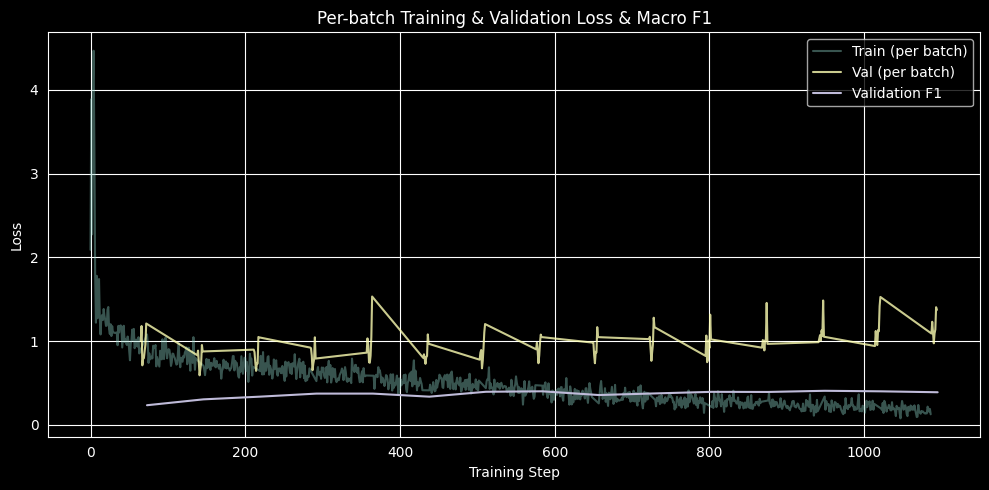

In [8]:
if TRAINING:
    plt.figure(figsize=(10, 5))
    plt.plot(global_steps, train_step_losses, alpha=0.4, label="Train (per batch)")
    plt.plot(val_steps, val_step_losses, alpha=0.8, label="Val (per batch)")
    plt.plot(val_macro_f1_steps, val_macro_f1, alpha=1, label="Validation F1")

    plt.xlabel("Training Step")
    plt.ylabel("Loss")
    plt.title("Per-batch Training & Validation Loss & Macro F1")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{base_save_location}/Unsmoothed.png")


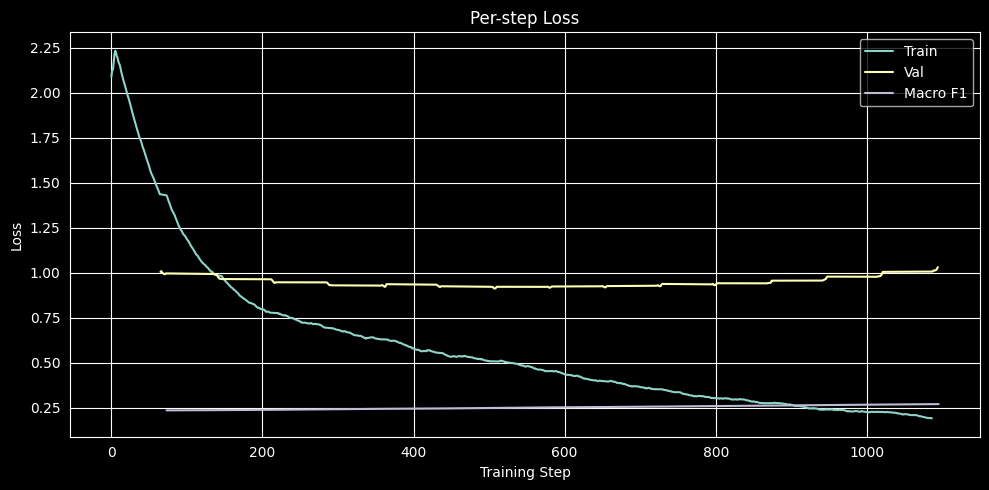

In [9]:
def ema(values, beta=0.98):
    smoothed = []
    avg = values[0]
    for v in values:
        avg = beta * avg + (1 - beta) * v
        smoothed.append(avg)
    return smoothed

if TRAINING:
    plt.figure(figsize=(10, 5))
    plt.plot(global_steps, ema(train_step_losses), label="Train")
    plt.plot(val_steps, ema(val_step_losses), label="Val")
    plt.plot(val_macro_f1_steps, ema(val_macro_f1), alpha=1, label="Macro F1")
    plt.xlabel("Training Step")
    plt.ylabel("Loss")
    plt.title("Per-step Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{base_save_location}/Smoothed.png")

In [10]:
test_conversations = load_meld_test_conversations(emotion_to_id)

In [11]:
test_dataset = MELDDataset(test_conversations, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=8,
    collate_fn=lambda x: collate_conversations(x, tokenizer)
)

In [12]:
test_f1 = test_model(
    model=model,
    dataloader=test_loader,
    device=device,
    emotion_labels=meld_labels,
    save_results=True,
    save_dir=f"{base_save_location}/classification_report.csv",
)
# also look into bert's special keywords

Testing: 100%|██████████| 9/9 [00:02<00:00,  3.23it/s]

Test Macro F1: 0.4059

Per-emotion results:
              precision    recall  f1-score   support

     neutral      0.725     0.808     0.764      1256
    surprise      0.554     0.566     0.560       281
        fear      0.174     0.080     0.110        50
    surprise      0.402     0.207     0.273       208
     sadness      0.474     0.607     0.532       402
         joy      0.348     0.118     0.176        68
     disgust      0.502     0.371     0.427       345

    accuracy                          0.613      2610
   macro avg      0.454     0.394     0.406      2610
weighted avg      0.592     0.613     0.595      2610



In [13]:
def ablation(model, dataloader, device, ablate):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            utterance_mask = batch["utterance_mask"].to(device)

            timestamps = batch["timestamps"].to(device)
            speakers = batch["speakers"].to(device)

            if ablate == "time_zero":
                timestamps = torch.zeros_like(timestamps)
            elif ablate == "time_shuffle":
                timestamps = timestamps[torch.randperm(timestamps.size(0))]
            elif ablate == "speaker_zero":
                speakers = torch.zeros_like(speakers)

            logits = model(
                input_ids, attention_mask,
                timestamps, speakers,
                labels, utterance_mask
            )

            preds = logits.argmax(-1)
            mask = labels != -1

            all_preds.append(preds[mask].cpu())
            all_labels.append(labels[mask].cpu())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    return f1_score(all_labels, all_preds, average="macro")

In [14]:
normal = ablation(model, val_loader, device, "none")
print("Normal:", normal)

Normal: 0.3893097533483053


In [15]:
time_zero = ablation(model, val_loader, device, "time_zero")
print(f"Time zero: {time_zero} Difference: {time_zero - normal}")

Time zero: 0.40316177160776745 Difference: 0.01385201825946214


In [16]:
time_shuffle = ablation(model, val_loader, device, "time_shuffle")
print(f"Time shuffle: {time_shuffle} Difference: {time_shuffle - normal}")

Time shuffle: 0.40830955714891787 Difference: 0.018999803800612558


In [17]:
speaker_zero = ablation(model, val_loader, device, "speaker_zero")
print(f"Speaker zero: {speaker_zero} Difference: {speaker_zero - normal}")

Speaker zero: 0.3993692492779245 Difference: 0.010059495929619189
